<a href="https://colab.research.google.com/github/aligoldenhat/MobileViT-Glaucoma/blob/main/mobilevit_glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#get the dataset

In [6]:
!pip install kaggle
!kaggle datasets download -d arnavjain1/glaucoma-datasets
!unzip glaucoma-datasets.zip -d /content/gloucoma-datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0207.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0208.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0209.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0210.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0211.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0212.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0213.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0214.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0215.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0216.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0217.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0218.png  
  inflating: 

### copy dataset to Google Drive - **DO NOT run it**

In [ ]:
#copy dataset to Google Drive
!mkdir -p /content/drive/MyDrive/glaucoma-datasets
!cp -d /content/gloucoma-datasets/ORIGA /content/drive/MyDrive/glaucoma-datasets/.

cp: -r not specified; omitting directory '/content/gloucoma-datasets/ORIGA'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# main

In [10]:
!pip install --upgrade albumentations
!pip install datasets evaluate

In [11]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

In [3]:
dataset_dir = '/content/gloucoma-datasets/ORIGA'
#dataset_dir = '/content/drive/MyDrive/glaucoma-datasets/ORIGA'
image_dir = os.path.join(dataset_dir, 'Images_Cropped')
labels_csv = os.path.join(dataset_dir, 'OrigaList.csv')

labels_df = pd.read_csv(labels_csv)
labels_df.drop(columns=['Eye', 'Set'], axis=1, inplace=True)
labels_df.columns=['Image_name', 'cdr', 'Label']

In [4]:
labels_df

,Image_name,cdr,Label
0,001.jpg,0.7097,0
1,002.jpg,0.6953,0
2,003.jpg,0.9629,0
3,004.jpg,0.7246,0
4,005.jpg,0.6138,0
...,...,...,...
645,646.jpg,0.6560,1
646,647.jpg,0.7365,1
647,648.jpg,0.5101,1
648,649.jpg,0.5227,0


## visualize dataset

In [ ]:
#DO NOT run this portion
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=0, p=0.5)
])

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.GaussianBlur(p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5)
])



def preprocessing(image_path, augment=True):
    # Load and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(image)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    enhanced_image = cv2.merge(clahe_channels)

    # Convert to float
    enhanced_image = enhanced_image.astype(np.float32) / 255.0

    # Apply augmentations if requested
    if augment:
        augmented = augmentations(image=enhanced_image)
        enhanced_image = augmented["image"]

    return enhanced_image

In [ ]:
labels_df

,Image_name,cdr,Label
0,001.jpg,0.7097,0
1,002.jpg,0.6953,0
2,003.jpg,0.9629,0
3,004.jpg,0.7246,0
4,005.jpg,0.6138,0
...,...,...,...
645,646.jpg,0.6560,1
646,647.jpg,0.7365,1
647,648.jpg,0.5101,1
648,649.jpg,0.5227,0


0


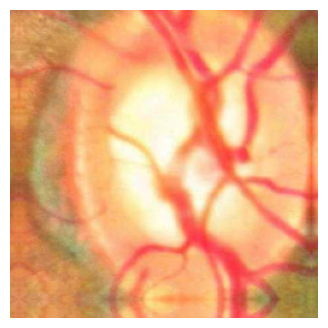

In [ ]:
num = 1
image_path = os.path.join(image_dir, labels_df.loc[num, 'Image_name'])
image = preprocessing(image_path, True)

print (labels_df.loc[num, 'Label'])
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
from transformers import MobileViTModel

mobilevit = MobileViTModel.from_pretrained("apple/mobilevit-small")
print(mobilevit)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

MobileViTModel(
  (conv_stem): MobileViTConvLayer(
    (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): SiLU()
  )
  (encoder): MobileViTEncoder(
    (layer): ModuleList(
      (0): MobileViTMobileNetLayer(
        (layer): ModuleList(
          (0): MobileViTInvertedResidual(
            (expand_1x1): MobileViTConvLayer(
              (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activation): SiLU()
            )
            (conv_3x3): MobileViTConvLayer(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

## finetune unfrozen layhers of mobilevit with levrage of crt

In [13]:
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
  import os
  import pandas as pd
  import numpy as np
  import cv2
  from PIL import Image
  import torch
  from torch import nn
  from torch.utils.data import Dataset, DataLoader
  from torchvision import transforms
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
  from transformers import MobileViTModel, MobileViTConfig, get_linear_schedule_with_warmup

  train_transforms = A.Compose([
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Rotate(limit=20, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
      A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
      A.GaussianBlur(p=0.3),
      A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
      A.Resize(height=256, width=256, p=1.0),
      A.Normalize(mean=(0.485, 0.456, 0.406),
                  std=(0.229, 0.224, 0.225)),
      ToTensorV2()
  ])


  val_transforms = A.Compose([
      A.Resize(height=256, width=256),
      A.Normalize(mean=(0.485, 0.456, 0.406),
                  std=(0.229, 0.224, 0.225)),
      ToTensorV2()
  ])

In [14]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image_name']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        cdr = torch.tensor(self.df.iloc[idx]['cdr'] / 1.0, dtype=torch.float)
        label = torch.tensor(self.df.iloc[idx]['Label'], dtype=torch.long)

        return image, cdr, label

In [15]:
class MobileViTGlaucomaClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(MobileViTGlaucomaClassifier, self).__init__()
        self.mobilevit = MobileViTModel.from_pretrained("apple/mobilevit-small")

        for param in self.mobilevit.parameters():
            param.requires_grad = False
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.3)

        self.classifier = nn.Sequential(
            nn.Linear(640 + 1, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )

    def unfreeze_last_layer(self):
        """unfreeze the last MobileViT layer and the final convolution layer"""
        for param in self.mobilevit.encoder.layer[4].parameters():
            param.requires_grad = True

        for param in self.mobilevit.conv_1x1_exp.parameters():
            param.requires_grad = True

    def forward(self, image, cdr):
        outputs = self.mobilevit(image)
        pooled_output = self.global_avg_pool(outputs.last_hidden_state)
        pooled_output = pooled_output.view(pooled_output.size(0), -1)
        combined = torch.cat((pooled_output, cdr.unsqueeze(1)), dim=1)

        out = self.dropout(combined)
        out = self.classifier(out)

        return out

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileViTGlaucomaClassifier(num_classes=2).to(device)
print (model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MobileViTGlaucomaClassifier(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (normal

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


train_dataset = GlaucomaDataset(df=labels_df, image_dir=image_dir, transform=train_transforms)
val_dataset = GlaucomaDataset(df=labels_df, image_dir=image_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) #change batch_size based on your gpu
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2) #change batch_size based on your gpu

model = MobileViTGlaucomaClassifier(num_classes=2).to(device)
model.unfreeze_last_layer()
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels_df['Label']),
                                     y=labels_df['Label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 100 #change this
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, cdrs, labels in train_loader:
        images = images.to(device)
        cdrs = cdrs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, cdrs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for images, cdrs, labels in val_loader:
            images = images.to(device)
            cdrs = cdrs.to(device)
            labels = labels.to(device)

            outputs = model(images, cdrs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    val_loss /= len(val_dataset)
    val_accuracy = correct / len(val_dataset)

    # # plot confusion matrix with magma colormap
    # cm = confusion_matrix(all_labels, all_preds)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=True,
    #             xticklabels=['Class 0', 'Class 1'],
    #             yticklabels=['Class 0', 'Class 1'], annot_kws={"size": 10})
    # plt.xlabel('Predicted Labels', fontsize=12)
    # plt.ylabel('True Labels', fontsize=12)
    # plt.title(f'Confusion Matrix (Epoch {epoch+1})', fontsize=14, pad=10)
    # plt.tight_layout()
    # plt.show()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    try:
        auc = roc_auc_score(all_labels, all_probs)
        print(f"ROC AUC Score: {auc:.4f}")
    except ValueError:
        print("ROC AUC Score: Cannot be computed due to lack of positive or negative samples.")


Epoch 1/100, Train Loss: 0.6925, Val Loss: 0.6840, Val Accuracy: 0.4815
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.34      0.49       482
           1       0.32      0.88      0.47       168

    accuracy                           0.48       650
   macro avg       0.61      0.61      0.48       650
weighted avg       0.74      0.48      0.49       650

ROC AUC Score: 0.6924
Epoch 2/100, Train Loss: 0.6853, Val Loss: 0.6708, Val Accuracy: 0.5738
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.48      0.63       482
           1       0.36      0.83      0.50       168

    accuracy                           0.57       650
   macro avg       0.63      0.66      0.56       650
weighted avg       0.76      0.57      0.60       650

ROC AUC Score: 0.7459
Epoch 3/100, Train Loss: 0.6748, Val Loss: 0.6586, Val Accuracy: 0.5754
Classification Report:
              pre

# build model to handle two datasets

In [ ]:
import pandas as pd
import os

# Paths to the datasets
origa_dir = '/content/gloucoma-datasets/ORIGA'
g1020_dir = '/content/gloucoma-datasets/G1020'

# Load ORIGA labels
origa_labels_csv = os.path.join(origa_dir, 'OrigaList.csv')
origa_labels_df = pd.read_csv(origa_labels_csv)
origa_labels_df.drop(columns=['Eye', 'Set', 'ExpCDR'], axis=1, inplace=True)
origa_labels_df.columns = ['Image_name', 'Label']

# Load G1020 labels
g1020_labels_csv = os.path.join(g1020_dir, 'G1020.csv')
g1020_labels_df = pd.read_csv(g1020_labels_csv)
g1020_labels_df.columns = ['Image_name', 'Label']

# Combine the datasets
combined_df = pd.concat([origa_labels_df, g1020_labels_df], ignore_index=True)

# Optional: Shuffle the combined dataset
combined_df = combined_df.sample(frac=1).reset_index(drop=True)


In [ ]:
combined_df

,Image_name,Label
0,505.jpg,1
1,310.jpg,0
2,image_1693.jpg,0
3,382.jpg,1
4,504.jpg,0
...,...,...
1665,image_50.jpg,0
1666,228.jpg,1
1667,507.jpg,1
1668,image_2729.jpg,0


In [ ]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, image_dirs, transform=None):
        """
        image_dirs: list of image directories
        """
        self.df = df
        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image_name']
        # Determine which directory the image is in
        for dir_path in self.image_dirs:
            img_path = os.path.join(dir_path, img_name)
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f"Image {img_name} not found in provided directories.")

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        label = torch.tensor(self.df.iloc[idx]['Label'], dtype=torch.long)

        return image, label


In [ ]:
import torch
from torch import nn
from transformers import MobileViTModel

class MobileViTGlaucomaClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(MobileViTGlaucomaClassifier, self).__init__()
        self.mobilevit = MobileViTModel.from_pretrained("apple/mobilevit-small")

        for param in self.mobilevit.parameters():
            param.requires_grad = False

        self.additional_cnn = nn.Sequential(
            nn.Conv1d(in_channels=640, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.3)

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def unfreeze_last_layer(self):
        """Unfreeze the last MobileViT layer and the final convolution layer."""
        for param in self.mobilevit.encoder.layer[4].parameters():
            param.requires_grad = True

        for param in self.mobilevit.conv_1x1_exp.parameters():
            param.requires_grad = True

    def forward(self, image):
        outputs = self.mobilevit(image)
        pooled_output = self.global_avg_pool(outputs.last_hidden_state)
        pooled_output = pooled_output.view(pooled_output.size(0), 640, -1)

        cnn_features = self.additional_cnn(pooled_output)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)

        out = self.dropout(cnn_features)
        out = self.classifier(out)

        return out


In [ ]:
from torch.utils.data import DataLoader

# Define image directories
image_dirs = [origa_dir + '/Images_Cropped', g1020_dir + '/Images_Cropped/img']

# Initialize the dataset
combined_dataset = GlaucomaDataset(df=combined_df, image_dirs=image_dirs, transform=train_transforms)

# Split into training and validation sets if needed
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['Label'], random_state=42)

train_dataset = GlaucomaDataset(df=train_df, image_dirs=image_dirs, transform=train_transforms)
val_dataset = GlaucomaDataset(df=val_df, image_dirs=image_dirs, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights based on the combined training data
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_df['Label']),
                                     y=train_df['Label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model = MobileViTGlaucomaClassifier(num_classes=2).to(device)
# Define optimizer with weight decay for regularization
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
num_epochs = 100
best_val_loss = float('inf')
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    val_loss /= len(val_dataset)
    val_accuracy = correct / len(val_dataset)

    # Early Stopping and Checkpointing
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     trigger_times = 0
    #     torch.save(model.state_dict(), "best_glaucoma_model.pth")
    # else:
    #     trigger_times += 1
    #     if trigger_times >= patience:
    #         print("Early stopping triggered!")
    #         break

    # Print Metrics
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    try:
        auc = roc_auc_score(all_labels, all_probs)
        print(f"ROC AUC Score: {auc:.4f}")
    except ValueError:
        print("ROC AUC Score: Cannot be computed due to lack of positive or negative samples.")

    # Step the scheduler
    scheduler.step()


KeyboardInterrupt: 

#save the model

In [ ]:
torch.save(model.state_dict(), "glaucoma_model.pth")
print("Model saved as glaucoma_model.pth")

Model saved as glaucoma_model.pth


In [ ]:
model = MobileViTGlaucomaClassifier(num_classes=2)
model.load_state_dict(torch.load("glaucoma_model.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

<ipython-input-17-d71641c8aa6d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("glaucoma_model.pth"))


MobileViTGlaucomaClassifier(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (normal

In [ ]:
dataset_dir = '/content/gloucoma-datasets/G1020'
#dataset_dir = '/content/drive/MyDrive/glaucoma-datasets/ORIGA'
image_dir = os.path.join(dataset_dir, 'Images_Cropped/img')
labels_csv = os.path.join(dataset_dir, 'G1020.csv')

new_labels_df = pd.read_csv(labels_csv)
#labels_df.drop(columns=['Eye', 'Set'], axis=1, inplace=True)
new_labels_df.columns=['Image_name', 'Label']

NameError: name 'os' is not defined

In [ ]:
new_labels_df

,Image_name,Label
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0
...,...,...
1015,image_3198.jpg,0
1016,image_3199.jpg,0
1017,image_3201.jpg,1
1018,image_3202.jpg,1


In [ ]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image_name']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        #cdr = torch.tensor(self.df.iloc[idx]['cdr'] / 1.0, dtype=torch.float)
        cdr = torch.tensor(1.0, dtype=torch.float)  # Using 1.0 as the dummy value
        label = torch.tensor(self.df.iloc[idx]['Label'], dtype=torch.long)

        return image, cdr, label

In [ ]:
new_val_dataset = GlaucomaDataset(df=new_labels_df, image_dir=image_dir, transform=val_transforms)
new_val_loader = DataLoader(new_val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store predictions and labels
all_labels = []
all_preds = []
all_probs = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, cdrs, labels in new_val_loader:
        images = images.to(device)
        cdrs = cdrs.to(device)
        labels = labels.to(device)

        outputs = model(images, cdrs)
        probs = torch.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming class 1 is the positive class

# Compute Metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Compute ROC AUC Score
try:
    auc = roc_auc_score(all_labels, all_probs)
    print(f"ROC AUC Score: {auc:.4f}")
except ValueError:
    print("ROC AUC Score: Cannot be computed due to lack of positive or negative samples.")


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       724
           1       0.33      0.15      0.20       296

    accuracy                           0.66      1020
   macro avg       0.52      0.51      0.50      1020
weighted avg       0.60      0.66      0.62      1020

ROC AUC Score: 0.5122


In [ ]:
# Visualize transformed images
def visualize_transforms(dataset, num_samples=5):
    for i in range(num_samples):
        image, _, label = dataset[i]
        image = val_transforms(image=np.array(image))['image']
        #image = image.permute(1, 2, 0).cpu().numpy()
        #image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

visualize_transforms(new_val_dataset)


NameError: name 'new_val_dataset' is not defined